In [4]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F

# ========== 1. Set Up Paths and Transforms ==========
data_dir = 'Covid19-dataset'

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [2]:
# ========== 2. Load Datasets ==========
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))
print("Classes:", class_names)

# ========== 3. Device Config ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train size: 251
Test size: 67
Classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [3]:
# ========== 4. Define Custom CNN (Optional) ==========
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 56, 56]
        x = x.view(-1, 64 * 56 * 56)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# ========== 5. Initialize Custom Model ==========
model = CustomCNN(num_classes=len(class_names)).to(device)

# ========== 6. Loss and Optimizer ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [8]:
# ========== 7. Train the Model ==========
num_epochs = 20
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    # ===== Training Phase =====
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ===== Test Phase =====
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy Calculation
    test_epoch_loss = test_loss / len(test_loader.dataset)
    test_epoch_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} - "
          f"Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.4f}")


Epoch [1/20] - Train Loss: 0.1067, Train Acc: 0.9562 - Test Loss: 0.4405, Test Acc: 0.8955
Epoch [2/20] - Train Loss: 0.1056, Train Acc: 0.9562 - Test Loss: 0.4403, Test Acc: 0.9254
Epoch [3/20] - Train Loss: 0.1012, Train Acc: 0.9602 - Test Loss: 0.4289, Test Acc: 0.9104
Epoch [4/20] - Train Loss: 0.1256, Train Acc: 0.9482 - Test Loss: 0.4390, Test Acc: 0.9254
Epoch [5/20] - Train Loss: 0.1115, Train Acc: 0.9522 - Test Loss: 0.4358, Test Acc: 0.9403
Epoch [6/20] - Train Loss: 0.1185, Train Acc: 0.9482 - Test Loss: 0.4999, Test Acc: 0.9104
Epoch [7/20] - Train Loss: 0.1272, Train Acc: 0.9442 - Test Loss: 0.4629, Test Acc: 0.9403
Epoch [8/20] - Train Loss: 0.1073, Train Acc: 0.9522 - Test Loss: 0.4589, Test Acc: 0.9104
Epoch [9/20] - Train Loss: 0.0889, Train Acc: 0.9681 - Test Loss: 0.4463, Test Acc: 0.9254
Epoch [10/20] - Train Loss: 0.0936, Train Acc: 0.9562 - Test Loss: 0.4424, Test Acc: 0.9254
Epoch [11/20] - Train Loss: 0.1158, Train Acc: 0.9482 - Test Loss: 0.4463, Test Acc: 0.92

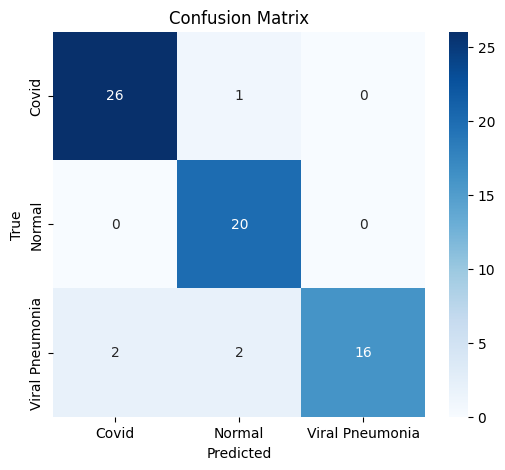


Classification Report:
                 precision    recall  f1-score   support

          Covid       0.93      0.96      0.95        27
         Normal       0.87      1.00      0.93        20
Viral Pneumonia       1.00      0.80      0.89        20

       accuracy                           0.93        67
      macro avg       0.93      0.92      0.92        67
   weighted avg       0.93      0.93      0.92        67



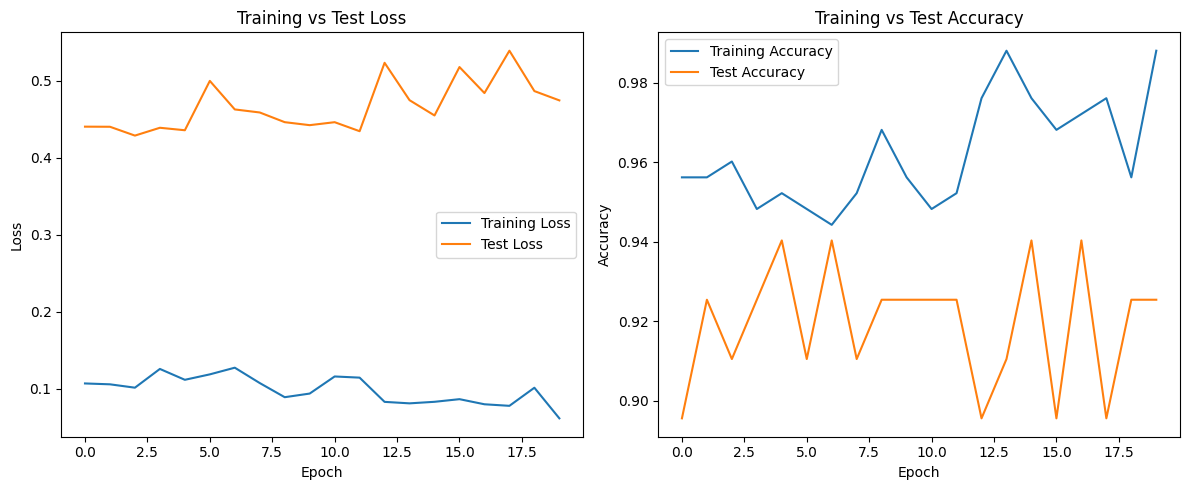

In [9]:
# ========== 10. Confusion Matrix ==========
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ========== 11. Classification Report ==========
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ========== 12. Plot Loss and Accuracy ==========
plt.figure(figsize=(12, 5))

# Plot Loss (Training + Test)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()

# Plot Accuracy (Training + Test)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
